In [4]:
from imports import *

from keras.layers import Input, Dense, Activation, Reshape
from keras.layers.recurrent import LSTM
from keras.models import Model
from keras.optimizers import Adam
import re

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory



Keras version: 2.1.5


In [5]:
PATH= './data'
df_raw = pd.read_csv(PATH+'/fra.txt', delimiter='\t', error_bad_lines=False, header=None, names=['en', 'fr'])

In [6]:
df_raw.head()

,en,fr
0,Go.,Va !
1,Hi.,Salut !
2,Run!,Cours !
3,Run!,Courez !
4,Wow!,Ça alors !


In [7]:
lang1 = 'en'
lang2 = 'fr' # 'ar'
#english_max_sentence_length = 250
#arabic_max_sentence_length = 260
df_raw.count()[0], df_raw[lang1].str.len().max(), df_raw[lang2].str.len().max()

(160538, 286, 360)

In [8]:
#Pre-process text data

In [9]:
# english characters 
english_chars = [char for char in 'abcdefghijklmnopqrstuvwxyz1234567890']
english_chars_num = len(english_chars)
english_char_stop = np.zeros((english_chars_num))
english_cleanup_regex = '[?!\.,/]'

# arabic characters 
arabic_chars = [char for char in '1234567890ابتثجحخدذرزسشصضطظعغفقكلمنهويءآٱأإةؤئى']
arabic_chars_num = len(arabic_chars)
arabic_char_stop = np.zeros((arabic_chars_num))
arabic_cleanup_regex = '[ـ،؛؟٫٬٠]'

# french characters 
french_chars = [char for char in 'abcdefghijklmnopqrstuvwxyz1234567890']
french_chars_num = len(english_chars)
french_char_stop = np.zeros((english_chars_num))
french_cleanup_regex = '[?!\.,/]'

# parameters for the source and destination languages
params = {
    'en': {
        'chars': english_chars,
        'chars_num': english_chars_num,
        'char_stop': english_char_stop,
        'cleanup_regex': english_cleanup_regex, 
        'max_sentence_length': 70
    },
    'fr': {
        'chars': french_chars,
        'chars_num': french_chars_num,
        'char_stop': french_char_stop,
        'cleanup_regex': french_cleanup_regex, 
        'max_sentence_length': 70
    }
}

In [13]:
# transform a sentence into an matrix of dimension (max_sentence_en, num_english_characters)
def one_hot_encoding(encodings, sentence, lang):
    """one hot encoding using the given characters and encoding length
    """
    if lang not in params.keys():
        print('unknown language', lang)
        return
    p = params[lang]
    chars, length, max_len, stop_char = p['chars'], p['chars_num'], p['max_sentence_length'], p['char_stop']
    for index in range(len(sentence)):
        char = sentence[index]
        # consider only characters in dictionnary
        if char in chars:
            idx = chars.index(char)
            onehot = np.zeros((length))
            onehot[idx] = 1
            encodings[index] = onehot
    # append padding to the end of the encoded sentence
    padding = max_len - len(sentence)
    for i in range(padding):
        encodings[len(sentence) + i] = stop_char

# shift the given encoding array to the right
def shift_right(encodings, lang):
    # check if the language is known or not
    if lang not in params.keys():
        print('unknown language', lang)
        return
    target, stop = [], []
    p = params[lang]
    target = np.zeros((num_pairs, p['max_sentence_length'], p['chars_num']))
    stop = p['char_stop']    
    # shift
    rows, sentences, chars = encodings.shape
    for r in range(rows):
        for s in range(sentences-1):
            target[r][s] = encodings[r][s+1]
        target[r][sentences-1] = stop
    return target

In [14]:
# for each language
languages = params.keys()
for lang in languages:
    # lowercase everything
    df_raw[lang] = df_raw[lang].str.lower()
    # trim sentences
    df_raw[lang] = df_raw[lang].str.strip()
    # remove stop words
    df_raw[lang] = df_raw[lang].map(lambda x: re.sub(params[lang]['cleanup_regex'], '', x))
    # filter-out long sentences
    df_raw = df_raw[(df_raw[lang].str.len()<=params[lang]['max_sentence_length'])]

num_pairs = df_raw.count()[0]
df_raw.head()

,en,fr
0,go,va
1,hi,salut
2,run,cours
3,run,courez
4,wow,Ça alors


In [15]:
# analyze sentences length
def plot_sentence_dist(df_raw, lang):
    df_agg = pd.DataFrame(df_raw[lang].map(lambda x: len(x)))
    df_agg[lang+'_count'] = 1
    return df_agg.groupby(lang).agg('count')

df_agg1 = plot_sentence_dist(df_raw, lang1)
df_agg2 = plot_sentence_dist(df_raw, lang2)

df_agg1[lang1+'_count'].describe(), df_agg2[lang2+'_count'].describe()

(count      69.000000
 mean     2251.014493
 std      2256.488888
 min         2.000000
 25%       236.000000
 50%      1296.000000
 75%      4294.000000
 max      6721.000000
 Name: en_count, dtype: float64, count      68.000000
 mean     2284.117647
 std      1744.458489
 min         1.000000
 25%       707.250000
 50%      1952.000000
 75%      3952.500000
 max      5230.000000
 Name: fr_count, dtype: float64)

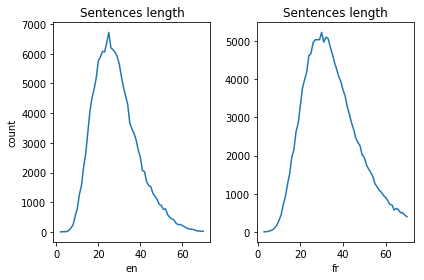

In [16]:
# plot source langauge length distribution
plt.subplot(1, 2, 1)
plt.plot(df_agg1)
plt.title('Sentences length')
plt.ylabel('count')
plt.xlabel(lang1)

# plot destination langauge length distribution
plt.subplot(1, 2, 2)
plt.plot(df_agg2)
plt.title('Sentences length')
plt.xlabel(lang2)

plt.tight_layout()
plt.show()

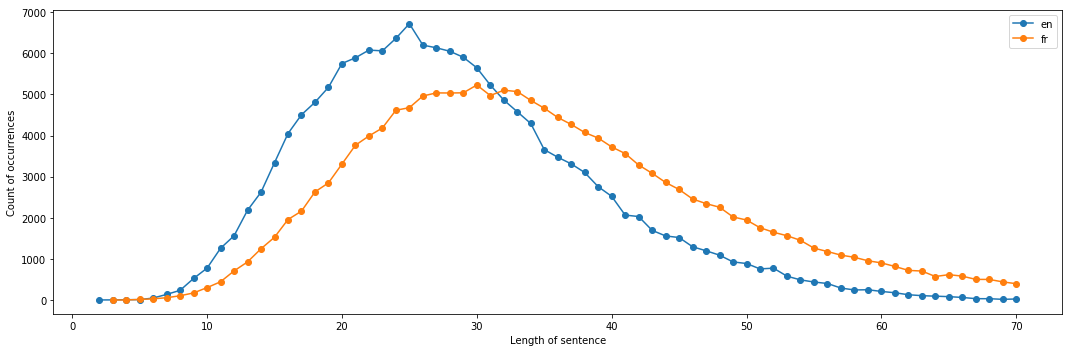

In [17]:
#df_agg1[lang1+'_count']
plt.figure(figsize=(15,5))
plt.plot(df_agg1[lang1+'_count'].keys(), df_agg1[lang1+'_count'].values, marker='o', label=lang1)
plt.plot(df_agg2[lang2+'_count'].keys(), df_agg2[lang2+'_count'].values, marker='o', label=lang2)
plt.legend()
plt.xlabel('Length of sentence')
plt.ylabel('Count of occurrences')
plt.tight_layout()
plt.show()

In [18]:
# Seq2Seq input

In [19]:
encodings = {
    'fr': np.zeros((num_pairs, params['fr']['max_sentence_length'], params['fr']['chars_num'])),
    'en': np.zeros((num_pairs, params['en']['max_sentence_length'], params['en']['chars_num']))
}
# one hot encode sentence characters
index = 0
for row_idx, row in df_raw.iterrows():
    for lang in encodings.keys():
        one_hot_encoding(encodings[lang][index], row[lang], lang)
    index += 1
print(encodings['en'].shape, encodings['fr'].shape)

((155320, 70, 36), (155320, 70, 36))


In [20]:
# A 3D array of shape (num_pairs, max_sentence_en, num_english_characters) containing a one-hot vectorization of the English sentences.
encoder_input_data = encodings['en']

# A 3D array of shape (num_pairs, max_sentence_ar, num_arabic_characters) containg a one-hot vectorization of the Arabic sentences.
decoder_input_data = encodings['fr']

# Same as decoder_input_data but offset by one timestep. decoder_target_data[:, t, :] will be the same as decoder_input_data[:, t + 1, :].
decoder_target_data = shift_right(encodings['fr'], 'fr')

decoder_input_data.shape, decoder_input_data.shape, decoder_target_data.shape

((155320, 70, 36), (155320, 70, 36), (155320, 70, 36))

In [21]:
decoder_input_data.shape, decoder_input_data[0][1]

((155320, 70, 36),
 array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]))

In [22]:
decoder_target_data.shape, decoder_target_data[0][0]

((155320, 70, 36),
 array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]))

In [23]:
# LSTM-based Architecture

In [24]:
# 1- Training phase

In [25]:
# language model
max_token_lang1 = params['en']['chars_num']
max_sentence_length_lang1 = params['en']['max_sentence_length']
max_token_lang2 = params['fr']['chars_num']
max_sentence_length_lang2 = params['fr']['max_sentence_length']


batch_size = 64  # Batch size for training.
epochs = 10  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.

# initializer the shape of the input for the Encoder/Decoder
encoder_input = Input(shape=(None, max_token_lang1))
decoder_input = Input(shape=(None, max_token_lang2))

# Encoding-Decoding LSTM
encoder = LSTM(latent_dim, return_state=True)
decoder = LSTM(latent_dim, return_state=True, return_sequences=True)

# run english input sentence througth the encoder
encoder_input_reshaped = Reshape((max_sentence_length_lang1, max_token_lang1))(encoder_input)
_, h, c = encoder(encoder_input_reshaped)
# pass the hidden/context states from encoder to the decoder, along with the target Arabic sentence
encoder_input_reshaped = Reshape((max_sentence_length_lang2, max_token_lang2))(decoder_input)
out, _, _ = decoder(encoder_input_reshaped, initial_state=[h, c])
# generate the final output
out = Dense(max_token_lang2)(out)
decoder_outtput = Activation('softmax')(out)
# create the Keras model
model = Model(inputs=[encoder_input, decoder_input], outputs=[decoder_outtput])

adam = Adam() #Adam(lr=0.1, decay=0.0005)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 36)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 36)     0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 70, 36)       0           input_1[0][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 70, 36)       0           input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LS

In [27]:
samples = decoder_input_data.shape[0]

In [ ]:
model.fit(
    x=[encoder_input_data[:samples], decoder_input_data[:samples]],
    y=[decoder_target_data[:samples]],
    batch_size=batch_size,
    shuffle = True,
    epochs=epochs,
    validation_split=0.1
)

Train on 139788 samples, validate on 15532 samples
Epoch 1/10
139788/139788 [==============================] - 449s 3ms/step - loss: 0.5998 - acc: 0.2424 - val_loss: 0.9131 - val_acc: 0.3397
Epoch 2/10
 10176/139788 [=>............................] - ETA: 5:20 - loss: 0.4647 - acc: 0.2203